In [1]:
import os
os.chdir('/home/jpmarceaux/Simulations/KalmanFiltering_Sandia2021')
from kalman_gst import *
os.chdir('/home/jpmarceaux/Simulations/KalmanFiltering_Sandia2021/AdaptiveCircuit')
from pygsti.modelpacks import smq1Q_XYZI as std

In [2]:
def filter_dataset(prior_model, prior_covar, dataset, circ_list, 
                   Q_add, R_add, clip_range=[-1, 1],
                   max_itr=1, itr_eps=1e-4,
                   save_params_and_covars=False, save_prior_innovations=False, save_posterior_innovations=False, save_kgains=False):
    param_history = []
    covar_history = []
    prior_innovs = []
    post_innovs = []
    kgains = []
    
    ekf = ExtendedKalmanFilter(prior_model.copy(), prior_covar)
    if save_params_and_covars:
        param_history.append(prior_model.to_vector())
        covar_history.append(prior_covar)
    for circ in tqdm(circ_list):
        counts = dataset[circ].counts
        cvec = vector_from_outcomes(counts, 2**circ.width)
        innov, kgain = ekf.update(circ, cvec, clip_range=clip_range, Q=Q_add, R_additional=R_add, max_itr=max_itr, itr_eps=itr_eps)
        if save_prior_innovations:
            prior_innovs.append(innov)
        if save_kgains:
            kgains.append(kgain)
        if save_posterior_innovations:
            post_predict = vector_from_outcomes(ekf.model.probabilities(circ), 2**circ.width)
            post_innov = cvec/sum(cvec) - post_predict
            post_innovs.append(post_innov)
        if save_params_and_covars:
            param_history.append(ekf.model.to_vector())
            covar_history.append(ekf.P)
    return ekf.model, ekf.P, (param_history, covar_history, prior_innovs, post_innovs, kgains)

In [3]:
SEED = 2021
NUM_SHOTS = 256
np.random.seed(SEED)

In [4]:
# setup the datagen model
max_fogi_error_rate = 0.01
mdl_datagen = std.target_model('H+s')
basis1q = pygsti.baseobjs.Basis.cast('pp', 4)
gauge_basis = pygsti.baseobjs.CompleteElementaryErrorgenBasis(
                        basis1q, mdl_datagen.state_space, elementary_errorgen_types='HS')
mdl_datagen.setup_fogi(gauge_basis, None, None, reparameterize=True,
                     dependent_fogi_action='drop', include_spam=True)
ar = mdl_datagen.fogi_errorgen_components_array(include_fogv=False, normalized_elem_gens=True)
target_model = mdl_datagen.copy()
np.random.seed(SEED)
ar = max_fogi_error_rate * np.random.rand(len(ar))
mdl_datagen.set_fogi_errorgen_components_array(ar, include_fogv=False, normalized_elem_gens=True)

In [5]:
# check that the datagen model is CPTP and print metrics w.r.t. the target model
print('Model is CPTP... ', model_is_cptp(mdl_datagen))
print('avg. gate-set infidelity: ', avg_gs_infidelity(mdl_datagen, target_model))
print('mean square error: ', mserror(mdl_datagen, target_model))

Model is CPTP...  True
avg. gate-set infidelity:  0.009278804429917908
mean square error:  0.000771129612974869


In [6]:
# make an edesign and simulate the data
maxLengths = [1,2,4, 8]
edesign = pygsti.protocols.StandardGSTDesign(target_model, std.prep_fiducials(), std.meas_fiducials(),
                                                std.germs(), maxLengths)
dataset = pygsti.data.simulate_data(mdl_datagen, edesign, NUM_SHOTS, seed=SEED) #, sample_error='none')

In [7]:
mle_estimates, edesigns = make_mle_estimates(dataset, std, target_model, maxLengths)

--- Iterative GST: [##################################################] 100.0%  128 circuits ---
Iterative GST Total Time: 0.8s
--- Iterative GST: [##################################################] 100.0%  258 circuits ---
Iterative GST Total Time: 1.2s
--- Iterative GST: [##################################################] 100.0%  531 circuits ---
Iterative GST Total Time: 1.7s
--- Iterative GST: [##################################################] 100.0%  874 circuits ---
Iterative GST Total Time: 2.5s


In [8]:
germ_length_ranges = {
    0: [0, 92], 
    1: [92, 168], 
    2: [168, 285], 
    3: [285, 448],
    4: [448, 616]
}

In [13]:
# run a Kalman filter in the usual way
prior_covar = 0.001*np.eye(target_model.num_params)
usual_post_model, usual_post_covar, saved_data = filter_dataset(target_model, prior_covar, dataset, edesign.circuit_lists[-1], 
    None, None, clip_range=[-1, 1],
    max_itr=1, itr_eps=1e-4,
    save_params_and_covars=True, save_prior_innovations=False, save_posterior_innovations=False, save_kgains=False)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 874/874 [00:44<00:00, 19.61it/s]


In [16]:
usual_parameter_history = saved_data[0]
usual_covar_history = saved_data[1]

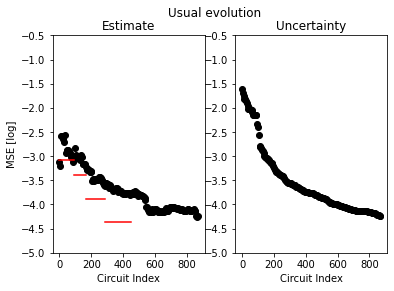

In [15]:
%matplottarget_model inline
plt_spacing = 5
yrange = [-5, -0.5]
make_error_plot('Usual evolution', usual_parameter_history, mdl_datagen.to_vector(), usual_covar_history, yrange, mle_estimates, germ_length_ranges, plt_spacing)

In [12]:
from filterpy.kalman import UnscentedKalmanFilter, MerweScaledSigmaPoints
from filterpy.common import Q_discrete_white_noise

In [20]:
model = target_model
P = 0.001*np.eye(target_model.num_params)
circ_list = edesign.circuit_lists[-1]

In [18]:
def fx(x, dt):
    return x

def model_wrapper(x_state, circ, model):
    model.from_vector(x_state)
    return vector_from_outcomes(model.probabilities(circ), 2**circ.width)

model = target_model
P = 0.1*np.eye(model.num_params)

dt = 1
points = MerweScaledSigmaPoints(model.num_params, alpha=.1, beta=2., kappa=-1)
ukf = UnscentedKalmanFilter(model.num_params, 2, dt=0, hx=model_wrapper, fx=fx, points=points)
ukf.Q = 1e-9*np.eye(model.num_params)
R_add = 1e-9*np.eye(2)
ukf_filter_model = model.copy()

ukf.x = target_model.to_vector()
ukf.P = P

In [21]:
ukf_model_vectors = dict()
ukf_covars = dict()

idx = 0
ukf_model_vectors[idx] = ukf.x
ukf_covars[idx] = ukf.P
idx += 1

# run over the largest set of GST circuits
for circ in tqdm(circ_list):
    counts = dataset[circ].counts
    cvec = vector_from_outcomes(counts, 2**circ.width)
    freq = cvec/sum(cvec)
    #req = cvec/sum(cvec)

    #_filter_prior = vector_from_outcomes(ekf.model.probabilities(circ), 2**circ.width)
    #ata_prior_innnovs[idx] = freq - p_filter_prior
    
    R_obs = categorical_covar(freq)/sum(cvec)
    ukf.predict()
    ukf.update(freq, R=R_obs+R_add, circ=circ, model=ukf_filter_model)
    
    #kgain = ekf.update_approx(circ, cvec, jdict[circ], hdict[circ], max_itr, max_itr_epsilon, Q_add, R_add)
    
    
    ukf_model_vectors[idx] = ukf.x
    ukf_covars[idx] = ukf.P

    idx += 1
num_circs = idx

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 874/874 [03:37<00:00,  4.02it/s]


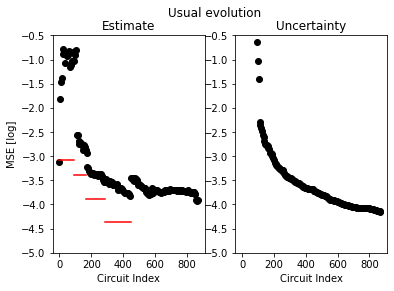

In [22]:
plt_spacing = 5
yrange = [-5, -0.5]
make_error_plot('Usual evolution', ukf_model_vectors, mdl_datagen.to_vector(), ukf_covars, yrange, mle_estimates, germ_length_ranges, plt_spacing)

# a simple score function 

We'll compare the the ratio of the product of the largest N eigenvalues of the prior and posterior $P$ to pick the best circuit

The Kalman update for the covariance is
$$ P_\text{post} = (1 - K_k H_k) P_\text{prior} $$
where the Kalman gain is 
$$ K_k = P_\text{prior} H_k^T (H_k P_{\text{prior}} H_k^T + R_k)^{-1} $$

To estimate circuit shot noise, we'll use a pseduo-count vector:
$$ 
    \vec{\alpha} = N \vec{p}_\text{estimate} + \vec{1}
$$
and the covariance
$$
    R_k = \frac{1}{N+d+1} \bigg( \frac{\text{diag}( \vec{\alpha}) }{N+d} - \frac{ \alpha \alpha^T}{(N+d)^2} \bigg)
$$

In [23]:
def largest_n_evals(matrix, num_evals):
    evals = np.linalg.eigvals(matrix)
    sorted_evals = np.argsort(evals)
    return sorted_evals[0:num_evals]

In [32]:
def find_best_circuit(circ_list, model, covar, num_shots, num_evals=10):
    """
    The simpliest function to find the best next circuit
        
    We estimate the observation noise for each circuit using the filter's prediction
    
    The algo is to go through each circuit and assign a score per:
        1) estimate the sampling noise
        2) calculate the model jacobian
        3) calculate the kgain
        4) assign a score as the ratio of the largest n evals of the prior and posterior
    Pick the smallest score
    """
    prior_score = np.prod(largest_n_evals(covar, num_evals))
    ratios = dict()
    for circ in tqdm(circ_list):
        hdims = 2**circ.width
        # simulate circuit probs
        p_model = vector_from_outcomes(model.probabilities(circ), hdims)
        # estimate sampling covar
        pseudo_counts = num_shots*p_model + np.ones(hdims)
        sampling_covar = (1/(num_shots + hdims + 1)) * (
            np.diag(pseudo_counts)/(num_shots + hdims) + 
            np.outer(pseudo_counts, pseudo_counts)/(num_shots + hdims)**2
        )
        # calculate kgain
        jac = matrix_from_jacob(model.sim.dprobs(circ), hdims) 
        kgain = covar@jac.T@np.linalg.pinv(jac@covar@jac.T + sampling_covar)
        # find the resulting posterior covariance
        post_covar = (np.eye(covar.shape[0]) - kgain@jac)@covar
        post_score = np.prod(largest_n_evals(covar, num_evals))
        ratios[circ] = np.log(prior_score) - np.log(post_score)
    best_score = max(ratios.values())
    best_circuits = [key for key in ratios if ratios[key] == best_score]
    return best_circuits[0], ratios

In [33]:
find_best_circuit(circ_list, target_model, P, 256, num_evals=3)

  0%|                                                                                                                                                                                                                | 0/874 [00:00<?, ?it/s]/tmp/ipykernel_25234/165580232.py:32: RuntimeWarning: divide by zero encountered in log
  ratios[circ] = np.log(prior_score) - np.log(post_score)
/tmp/ipykernel_25234/165580232.py:32: RuntimeWarning: invalid value encountered in double_scalars
  ratios[circ] = np.log(prior_score) - np.log(post_score)
100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 874/874 [00:42<00:00, 20.39it/s]


IndexError: list index out of range